神经网络文本分类是一种使用神经网络模型来对文本进行分类的方法。它的特点包括：

1. **端到端的学习**：神经网络文本分类可以直接从原始文本数据中学习特征表示和分类模型，无需手动提取特征。

2. **适应性强**：神经网络可以适应不同类型和长度的文本，并且能够处理大规模的文本数据。

3. **能够捕获上下文信息**：神经网络可以通过学习词语之间的关系和上下文信息来提取丰富的语义特征。

4. **可扩展性**：神经网络可以通过增加层数或神经元数量来提高模型的性能，同时也可以应用于多分类、多标签分类等不同类型的文本分类任务。

5. **需要大量标注数据**：神经网络文本分类通常需要大量的标注数据来训练模型，以获得较好的性能。

6. **黑盒性**：由于神经网络模型的复杂性，其内部的工作机制通常被视为黑盒，难以解释模型的决策过程。

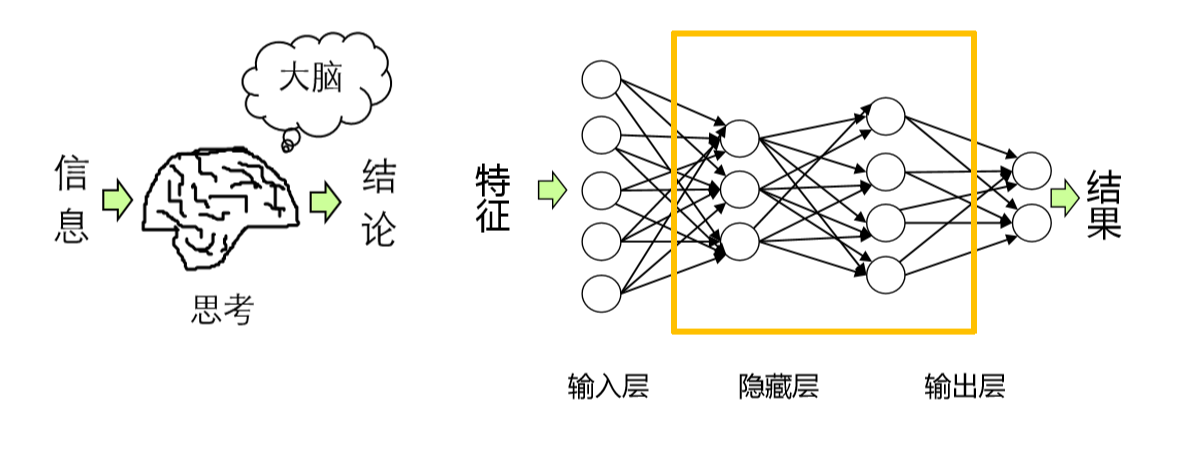

In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
import numpy as np
from gensim.models import KeyedVectors
import torch.optim as optim
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib

In [2]:
#读取数据
df = pd.read_csv('分词后data.csv')
df = df.dropna()
print(df.head())

                                                  文本  标签
0                       商业秘密 秘密性 维系 商业价值 垄断 地位 前提条件    0
1  南口 阿玛施 新春 第一批 限量 春装 店 春暖花开 淑女 裙冰 蓝色 公主 衫 气质 粉小...   1
2                                 带给 常州 一场 壮观 视觉 盛宴    0
3                                     原因 不明 泌尿系统 结石    0
4                                    年 盐城 拉回来 麻麻 嫁妆    0


In [3]:
data = df['文本'].tolist()
label = df['标签'].tolist()
print(len(data), len(label)) #查看语料信息
print(Counter(label)) #查看不同标签文本数量

1241 1241
Counter({0: 1119, 1: 122})


In [4]:
texts = [each.split() for each in data]
print(texts[0:5])

[['商业秘密', '秘密性', '维系', '商业价值', '垄断', '地位', '前提条件'], ['南口', '阿玛施', '新春', '第一批', '限量', '春装', '店', '春暖花开', '淑女', '裙冰', '蓝色', '公主', '衫', '气质', '粉小', '西装', '冰丝', '女王', '长半裙', '皇'], ['带给', '常州', '一场', '壮观', '视觉', '盛宴'], ['原因', '不明', '泌尿系统', '结石'], ['年', '盐城', '拉回来', '麻麻', '嫁妆']]


In [5]:
#划分训练数据和测试数据
train_sets, test_sets, train_label, test_label = train_test_split(data, label, test_size=0.3, random_state=42)
print(len(train_sets), len(train_label))
print(len(test_sets), len(test_label))

868 868
373 373


In [6]:
print(train_sets[0:5])
print(train_label[0:5])

['菊叶 蛋汤 清补 江苏省 中医院 营养 科 营养师 汪燕 夏天 贪凉 食易伤 脾胃 ', '年 月 任教于 呼和浩特 新城区 苏虎街 实验 小学 ', '如果说 认了 亲戚 代表 腐败 ', '尊敬 客户 欢迎 致电 本店 公司 店 联营 万套 房源 多家 银行 合作 另本 公司 代理 多个 一手 房 楼盘 专业 团队 竭诚 为您服务 预约 ', '同事 浙江 西塘 带 回来 礼物 ']
[0, 0, 0, 1, 0]


In [7]:
#word2vec词向量
cn_model = KeyedVectors.load_word2vec_format('..\\4 词向量文档表示模型\\sgns.weibo.word.bz2', binary=False)

In [8]:
#对每个句子的所有词向量取均值，来生成一个句子的vector
def build_sentence_vector(sentence,size,w2v_model):
    sen_vec=np.zeros(size).reshape((1,size))
    count=0
    for word in sentence:
        try:
            sen_vec+=w2v_model[word].reshape((1,size))
            count+=1
        except KeyError:
            continue
    if count!=0:
        sen_vec/=count
    return sen_vec

In [9]:
train_data = np.zeros([len(train_sets),300], dtype = float)
for i in range(0, len(train_sets)):
    train_data[i] = build_sentence_vector(train_sets[i], 300, cn_model)
test_data = np.zeros([len(test_sets),300], dtype = float)
for i in range(0, len(test_sets)):
    test_data[i] = build_sentence_vector(test_sets[i], 300, cn_model)
print(train_data.shape)

(868, 300)


In [10]:
train_x = torch.FloatTensor(train_data)
train_y = torch.LongTensor(train_label)
test_x = torch.FloatTensor(test_data)
test_y = torch.LongTensor(test_label)

In [11]:
# 定义神经网络类
class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNN, self).__init__()
        # self.layer1 = nn.Linear(input_size, hidden_size)
        # self.layer2 = nn.Linear(hidden_size, output_size)
        # self.relu = nn.ReLU()
        self.seq = nn.Sequential(nn.Linear(input_size,hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, output_size))

    def forward(self, x):
        # x = self.layer1(x)
        # x = self.relu(x)
        # x = self.layer2(x)
        x = self.seq(x)
        return x

## nn.Linear有什么用？

**nn.Linear** 是 **PyTorch** 中用于创建**线性层**的类。这个线性层也被称为**全连接层**，它的作用是将输入与权重矩阵相乘，然后加上偏置，并通过激活函数进行非线性变换

具体来说，**nn.Linear** 的基本定义如下：

- `nn.Linear(in_features, out_features, bias=True)`：其中
    - `in_features` 表示输入的神经元个数。
    - `out_features` 表示输出的神经元个数。
    - `bias` 是一个布尔值，表示是否包含偏置。

举个例子，如果我们创建一个具有2个输入特征和1个输出特征的线性层，可以这样写：

```python
from torch import nn

model = nn.Linear(2, 1)  # 输入特征数为2，输出特征数为1
input = torch.Tensor([1, 2])  # 给定一个样本，该样本有2个特征（这两个特征的值分别为1和2）
output = model(input)
```

在这个例子中，我们的输入是 `[1, 2]`，输出是 `[-1.4166]`。你还可以查看模型的参数来验证上述计算：

```python
# 查看模型参数
for param in model.parameters():
    print(param)
```

这将输出类似以下的参数：

```
Parameter containing:
tensor([[ 0.1098, -0.5404]], requires_grad=True)
Parameter containing:
tensor([-0.4456], requires_grad=True)
```

总之，**nn.Linear** 在神经网络中用于添加线性层，它对于构建神经网络、进行特征变换等任务非常有用

## 什么是ReLu?它有什么用？

**ReLU（Rectified Linear Unit）**，全称为**线性整流单元**，是在神经网络中常用的激活函数。它的主要作用是将输入值限制在一个非负的范围内：

- 当输入值小于0时，输出值为0。
- 当输入值大于等于0时，输出值等于输入值本身。

ReLU函数的表达式为：

$ f(x) = \max(0, x) $

**ReLU函数的优点**包括：

1. **计算简单**：ReLU的计算非常高效，不涉及复杂的数学运算。
2. **梯度不会消失**：相比于某些其他激活函数，如Sigmoid和Tanh，ReLU在训练过程中不容易出现梯度消失的问题。
3. **适用于处理非线性问题**：ReLU的非线性特性使其在深度学习中得到广泛的应用。

此外，ReLU的导数也很容易计算，这对于使用梯度下降法进行模型训练非常有利。

总之，ReLU是目前默认认为较好的非线性激活函数之一。它在神经网络中的应用使得神经元能够更好地解决复杂问题，同时避免了梯度消失的问题。

## 神经网络中为什么要用激活函数？有那几中常用的激活函数？

在神经网络中，激活函数是至关重要的组件之一。让我们深入探讨一下激活函数的作用以及常见的几种类型。

## 1. 激活函数的作用
激活函数在神经网络中具有以下作用：

- **引入非线性因素**：神经网络的每一层都是线性变换的堆叠。如果没有激活函数，整个网络只能表示线性函数，无法处理更复杂的非线性问题。激活函数的引入打破了这种线性关系，使得神经网络可以学习和表示更复杂的函数关系。

- **增强表达能力**：非线性激活函数使神经网络能够处理更为复杂的数据模式和特征。它们增加了网络的表达能力，使其能够逼近任意函数。

## 2. 常见的激活函数
以下是一些常见的激活函数：

1. **Sigmoid函数**：
   - 公式：$$f(x) = \frac{1}{1 + e^{-x}}$$
   - 取值范围：(0, 1)
   - 用途：主要用于二分类问题，将预测概率映射到(0, 1)区间。

2. **Tanh函数**：
   - 公式：$$f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$
   - 取值范围：(-1, 1)
   - 优点：输出以零为中心，比Sigmoid更好；在图像生成模型中应用较多。

3. **ReLU函数**：
   - 公式：$$f(x) = \max(0, x)$$
   - 优点：解决了梯度消失问题，计算速度快。

4. **Leaky ReLU函数**：
   - 公式：$$f(x) = \max(\alpha x, x)$$（其中$\alpha$是小于1的常数）
   - 优点：修正了ReLU中负数部分的问题。

5. **Softmax函数**：
   - 公式：$$f(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$$
   - 用途：多分类问题中将输出转化为概率分布。

这些激活函数各有优缺点，根据具体问题选择合适的激活函数。

In [12]:
# 定义超参数
input_size = len(train_x[0])  # 示例：输入特征的数量
hidden_size = 1000  # 示例：隐藏单元的数量
output_size = 2  # 示例：输出类别的数量
EPOCH = 300
LR = 0.0005 #学习率
len(train_x[0])

300

In [13]:
# 创建神经网络实例
model = TwoLayerNN(input_size, hidden_size, output_size)
print(model) #输出模型结构
total_params = 0
for name, parameters in model.named_parameters():
    if not parameters.requires_grad: continue
    print(name, ':', parameters.size())
    total_params += parameters.numel()
print("模型需要训练参数为：", total_params)

TwoLayerNN(
  (seq): Sequential(
    (0): Linear(in_features=300, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=2, bias=True)
  )
)
seq.0.weight : torch.Size([2, 300])
seq.0.bias : torch.Size([2])
seq.2.weight : torch.Size([2, 1000])
seq.2.bias : torch.Size([2])
模型需要训练参数为： 2604


In [14]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

f:\download\sd\sd-webui-aki-v4.5\python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## nn.CrossEntropyLoss()是什么？

`nn.CrossEntropyLoss()`是PyTorch中的一个损失函数。让我为你详细解释一下：

- **作用**：`CrossEntropyLoss`用于训练分类问题，特别是多类别分类问题。它计算输入的预测概率（logits）与目标之间的交叉熵损失。

- **输入**：输入预测的logits，不需要归一化或正数化。目标是类别的索引。

- **用途**：在训练神经网络时，我们使用交叉熵损失来衡量模型的预测与真实标签之间的差异，从而优化模型参数。

- **公式**：对于每个样本，交叉熵损失的计算公式如下：

  $$\ell(x, y) = -\sum_{c=1}^C w_{y_n} \log \frac{\exp(x_{n,y_n})}{\sum_{i=1}^C \exp(x_{n,i})} \cdot \mathbb{1}\{y_n \neq \text{ignore\_index}\}$$

  其中：
  - $x$ 是输入的logits。
  - $y$ 是目标类别的索引。
  - $w$ 是权重（可选，用于处理不平衡的训练集）。
  - $\text{ignore\_index}$ 是忽略的类别索引（可选）。

- **常见用法**：通常与LogSoftmax激活函数结合使用，形成完整的分类模型。如果你在训练多类别分类问题，`nn.CrossEntropyLoss()`是一个推荐的选择。

## 为什么要有损失函数？有哪几种常用的损失函数？

损失函数（Loss Function）在机器学习和深度学习中起着关键作用。让我详细解释一下：

- **作用**：损失函数用于衡量模型的预测值与真实值之间的差异或误差。它是一个数值评估指标，帮助我们理解模型的性能。

- **目的**：通过最小化损失函数，我们可以找到模型参数的最优值，从而提高模型的预测准确度。

- **分类**：损失函数分为回归损失（针对连续型变量）和分类损失（针对离散型变量）。

以下是一些常见的损失函数：

1. **均方差损失（Mean Squared Loss）**：
   - 衡量预测值与真实值之间的平方误差。
   - 适用于回归问题。

2. **平均绝对误差损失（Mean Absolute Error Loss）**：
   - 衡量预测值与真实值之间的绝对误差。
   - 对离群点更具鲁棒性。

3. **Huber损失**：
   - 结合了L1和L2损失的优点，平衡了鲁棒性和收敛速度。

4. **交叉熵损失函数（Cross Entropy Loss）**：
   - 用于分类问题，特别是多类别分类。
   - 衡量预测概率与真实标签之间的差异。

5. **Hinge损失**：
   - 用于支持向量机（SVM）等分类问题。
   - 鼓励正确分类的边界更远离数据点。

这些损失函数各有优缺点，根据具体问题选择合适的损失函数。

## optimizer = optim.Adam(model.parameters(), lr=LR)是什么意思

`optimizer = optim.Adam(model.parameters(), lr=LR)` 是一个设置优化器的代码行，用于训练神经网络模型。让我解释一下：

- `optim.Adam`：这是PyTorch中的Adam优化器，用于更新模型的参数。
- `model.parameters()`：这是模型的参数，即需要优化的权重和偏置。
- `lr=LR`：这是学习率（learning rate），用于控制参数更新的步长。

总之，这行代码的作用是创建一个Adam优化器，将模型的参数与指定的学习率关联起来，以便在训练过程中更新模型的参数。

## 什么是优化器？它有什么用？有哪几种常用的优化器？

**优化器**在深度学习中扮演着关键角色，它用于最小化**损失函数**，从而找到模型参数的最优值。让我们一起探讨一下优化器的作用、常见类型以及它们之间的区别。

1. **什么是优化器？**
    - 优化器的任务是在深度学习的反向传播过程中，引导模型参数朝着正确的方向更新，使得损失函数（目标函数）的值不断逼近全局最小。
    - 优化问题类似于站在山上某个位置，想要以最佳路线到达山下的最优点。梯度下降是几乎所有优化器的核心思想，其中梯度表示函数上升最快的方向，梯度的反方向则是函数下降最快的方向。

2. **常见的优化器类型**：
    - **随机梯度下降法（SGD）**：
        - 每次从训练集中随机选择一个样本进行学习。
        - 优点：训练速度快，有利于跳出局部极小值点。
        - 缺点：可能困在局部最优点或鞍点，沿陡峭方向震荡。
    - **SGD with Momentum**：
        - 引入一阶动量，抑制SGD的震荡。
        - 优点：缓解了局部最优点和振荡幅度过大的问题。
    - **SGD with Nesterov Acceleration**：
        - 进一步改进SGD，有利于跳出当前局部最优的沟壑。
        - 缺点：收敛速度较慢。
    - **AdaGrad（自适应学习率算法）**：
        - 根据历史梯度计算二阶动量，自适应调整学习率。
        - 优点：适用于不同参数的不同更新频率。
    - 其他优化器如**RMSProp**和**Adam**也被广泛使用。

总之，优化器在神经网络训练中起到至关重要的作用，帮助模型找到最优参数，从而提高准确率和召回率

In [15]:
train_losses = []
test_losses = []
for epoch in range(EPOCH):
    optimizer.zero_grad()
    output = model(train_x)
    loss = criterion(output, train_y)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    with torch.no_grad():
            test_output = model(test_x)
            test_loss = criterion(test_output, test_y)
            test_losses.append(test_loss.item())
            
    if (epoch + 1) % 10 == 0:
        _, predicted = torch.max(output, 1)
        correct = (predicted == train_y).sum().item()
        accuracy = correct / len(train_y)
        print(f"Epoch [{epoch + 1}/{EPOCH}], Loss: {loss.item():.4f}, Training Accuracy: {accuracy:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (868x2 and 1000x2)

这段代码是一个**训练神经网络模型的典型循环**，通常用于深度学习任务。让我逐步解释它：

1. `for epoch in range(EPOCH):`：这是一个循环，它会在每个**训练轮次（epoch）**中运行一次。`EPOCH` 是预先定义的训练轮次的总数。

2. `optimizer.zero_grad()`：这一行将模型的**梯度**清零，以准备计算新的梯度。

3. `output = model(train_x)`：这一行计算模型的输出。`train_x` 是输入数据，`model` 是我们要训练的神经网络模型。

4. `loss = CrossEntropyLoss(output, train_y)`：这一行计算损失函数。`CrossEntropyLoss` 是交叉熵损失函数，用于衡量模型输出与实际标签之间的差异。

5. `loss.backward()`：这一行计算损失函数对模型参数的**梯度**。这是反向传播的关键步骤。

6. `optimizer.step()`：这一行使用优化器来更新模型的参数，使得损失函数的值减小。优化器根据梯度信息来调整参数。

7. `if (epoch + 1) % 10 == 0:`：这一行检查是否达到了每10个轮次的时间点。

8. `_, predicted = torch.max(output, 1)`：这一行找到模型输出中概率最高的类别。

9. `correct = (predicted == train_y).sum().item()`：这一行计算预测正确的样本数量。

10. `accuracy = correct / len(train_y)`：这一行计算训练准确率。

11. `print(f"Epoch [{epoch + 1}/{EPOCH}], Loss: {loss.item():.4f}, Training Accuracy: {accuracy:.4f}")`：这一行打印每个轮次的损失和训练准确率。

总之，这段代码展示了一个典型的神经网络训练过程，包括前向传播、计算损失、反向传播、参数更新和性能评估。

In [ ]:
matplotlib.rcParams['font.sans-serif'] = 'SimHei' #matplotlib画图显示中文
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='训练集损失（Training Loss）')
plt.plot(test_losses, label='测试集损失（Testing Loss）')
plt.xlabel('轮次（Epoch）')
plt.ylabel('损失（Loss）')
plt.title('损失随轮次变化情况（Loss over Epochs）')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    model.eval()  # 设置模型为评估模式
    predicted_classes = torch.argmax(model(test_x), dim=1)
    print(classification_report(test_y, predicted_classes, digits=4, target_names = ['正常短信', '垃圾短信']))

这段代码用于**模型评估**，让我逐步解释它：

1. `with torch.no_grad():`：这是一个上下文管理器，用于在其内部禁用梯度计算。在评估模型时，我们不需要计算梯度，因此使用这个上下文管理器可以提高效率。

2. `model.eval()`：这一行将模型设置为**评估模式**。在评估模式下，模型不会进行参数更新，而是仅计算输出。

3. `predicted_classes = torch.argmax(model(test_x), dim=1)`：这一行计算模型在测试集上的预测结果。`test_x` 是输入数据，`model` 是我们要评估的神经网络模型。`torch.argmax` 返回每个样本预测结果中概率最高的类别。

4. `classification_report(test_y, predicted_classes, digits=4, target_names=['正常短信', '垃圾短信'])`：这一行生成一个分类报告，包括准确率、召回率、F1值等指标。`test_y` 是实际标签，`predicted_classes` 是预测的类别。

总之，这段代码用于评估模型在测试集上的性能，并打印出分类报告，以便分析模型的表现。